In [1]:
curr_dir = f'/user_data/vayzenbe/GitHub_Repos/hemispace' #CHANGE AS NEEEDED CAUSE ITS FOR VLAAAD

import sys
sys.path.insert(0,curr_dir)
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import scipy.stats as stats
import scipy
import statsmodels.api as s
from sklearn import metrics

import pdb
import hemispace_params as params

In [2]:
data_dir = params.data_dir
results_dir = params.results_dir
fig_dir = params.fig_dir

sub_info = params.sub_info
task_info = params.task_info

suf = params.suf
rois = params.rois
hemis = params.hemis

#load data summary
data_summary = pd.read_csv(f'{results_dir}/hemispace_summary_vals{suf}.csv')

#load subject info
sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')




In [3]:
def create_histplot(boot_data, sub_data, group,metric, title, save=True):
    bin_range = [np.min(boot_data)-np.std(boot_data), np.max(boot_data)+np.std(boot_data)]
    sns.histplot(boot_data, binrange = bin_range)
    #add x axis label
    plt.xlabel(metric)
    
    for sub, val in zip(sub_data['sub'], sub_data[metric]):
        
        
        #add a line for each patient
        plt.axvline(val, color = 'red')
        rand_int = np.random.randint(100,500)

        #for patients add their code
        if group == 'patient':
            #find code corresponding to sub
            sub_code = sub_info[sub_info['sub'] == sub]['code'].values[0]
            #add text for each patient
            plt.text(val+(np.std(boot_data)/3), rand_int, sub_code, color = 'red')

    #add title
    plt.title(title)

    #if save is true, save figure
    if save:
        file_name = title.replace(' ','_')
        file_name = f'{metric}_{file_name}{suf}'
        plt.savefig(f'{fig_dir}/hist/indiv/{file_name}.png')
    
    #random number between 100 and 500
   


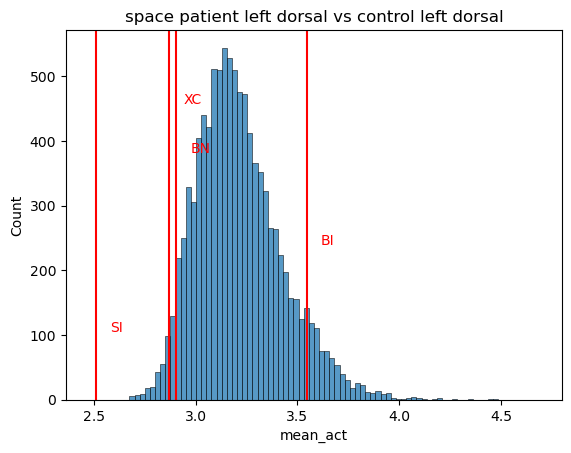

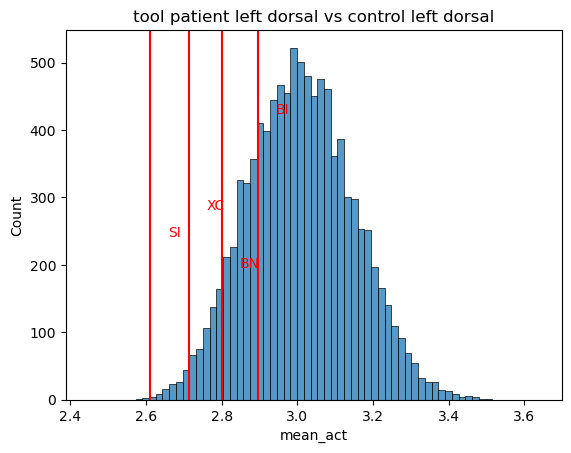

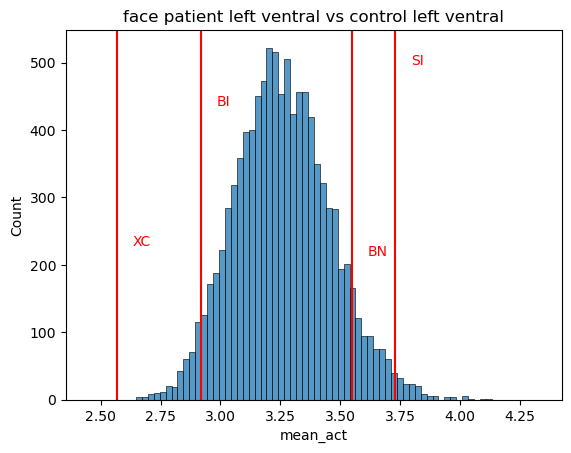

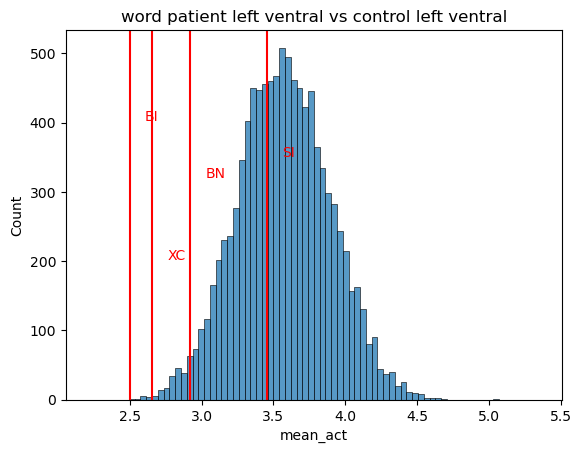

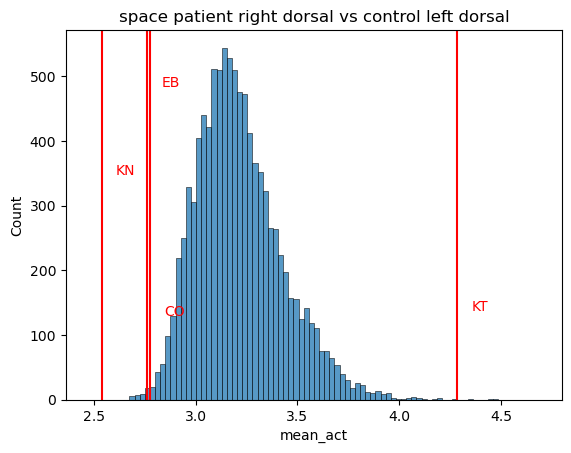

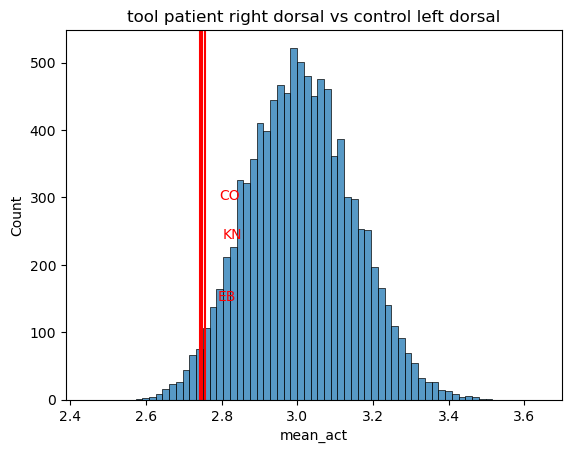

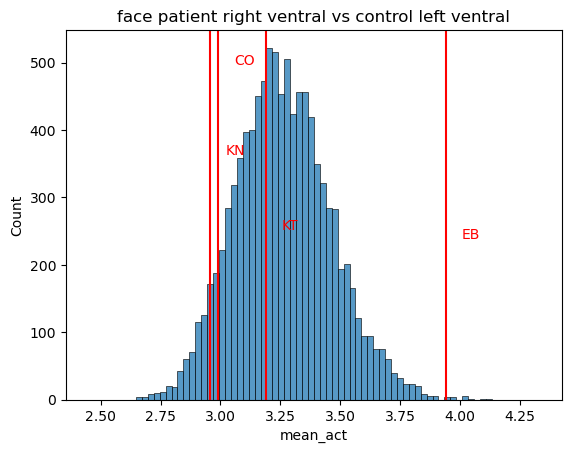

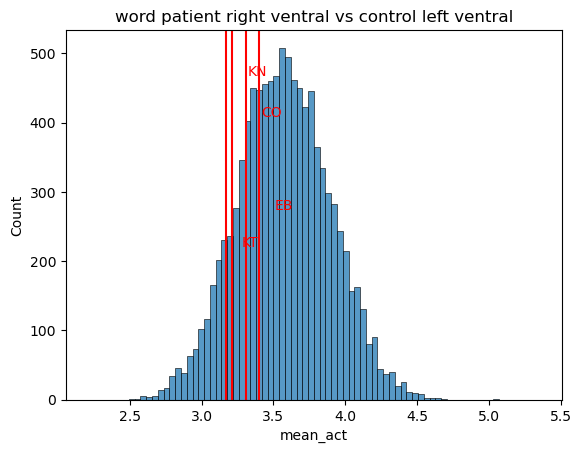

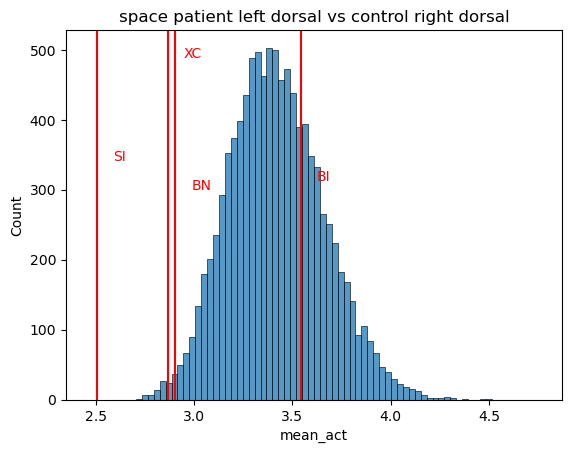

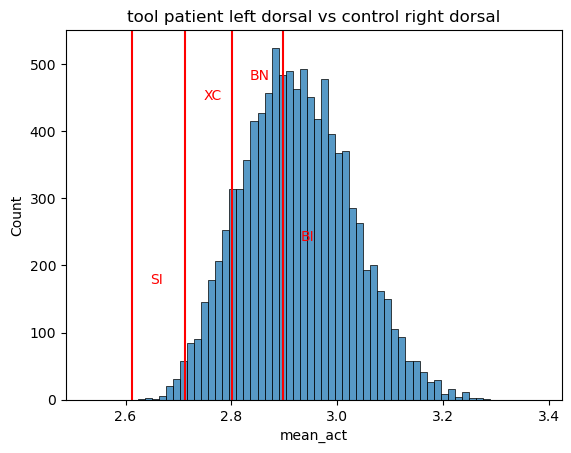

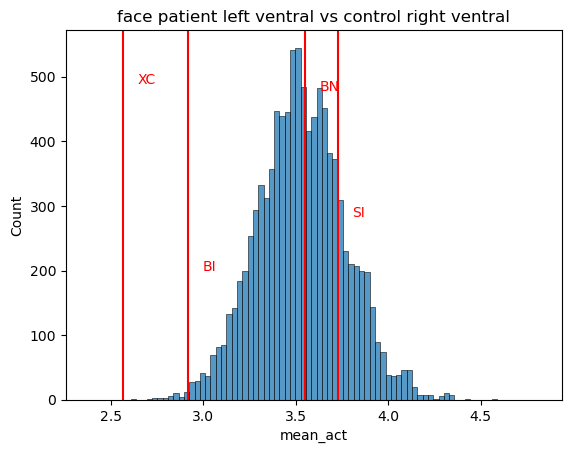

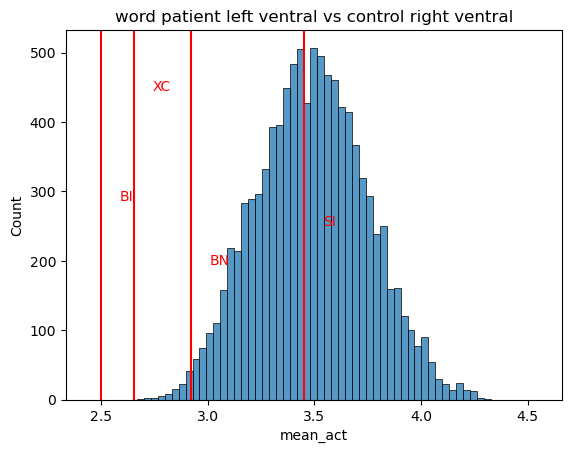

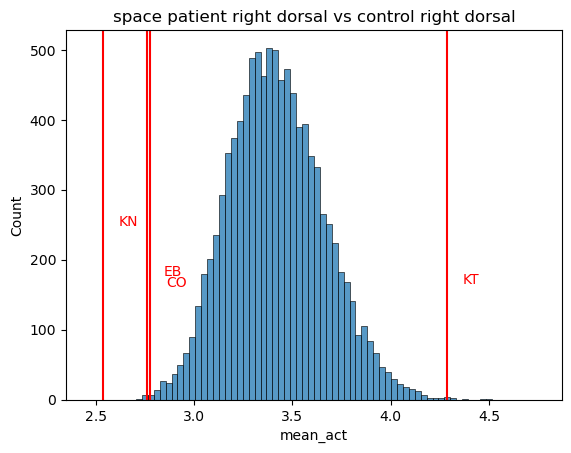

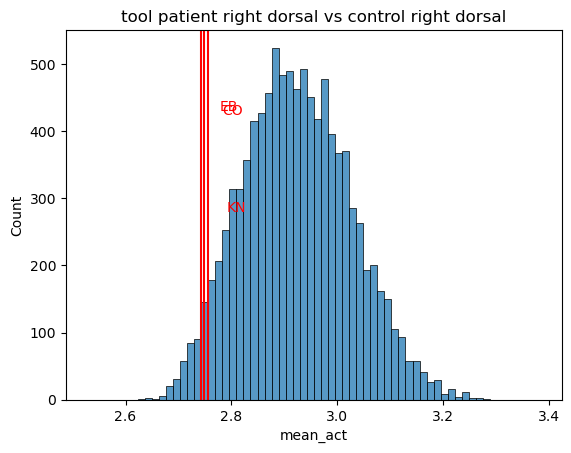

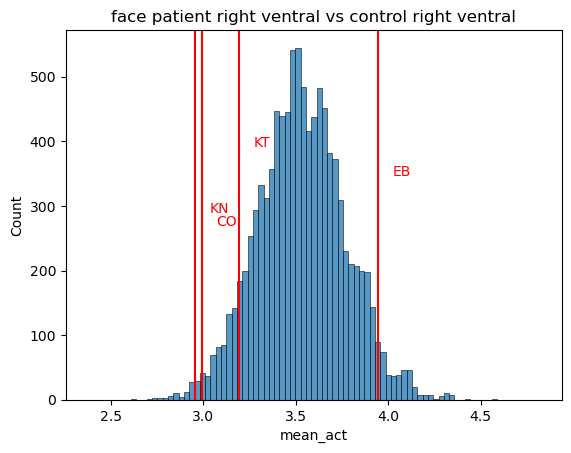

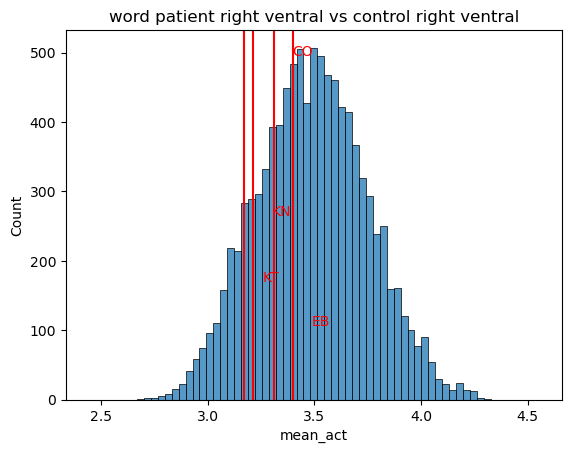

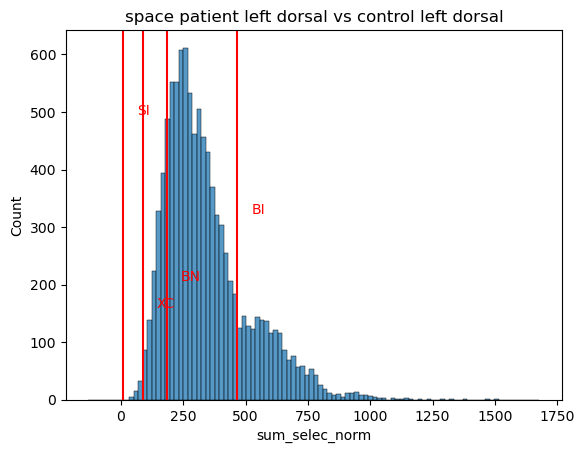

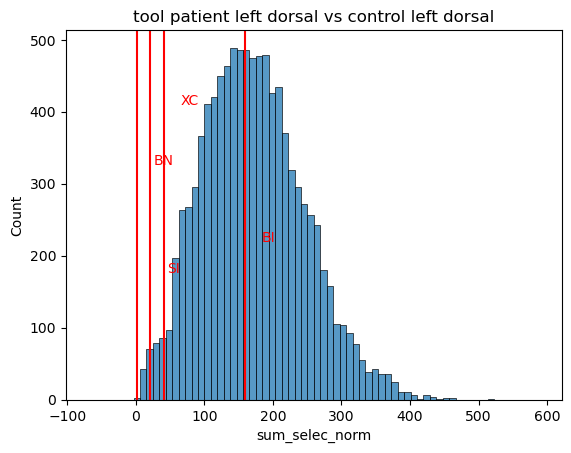

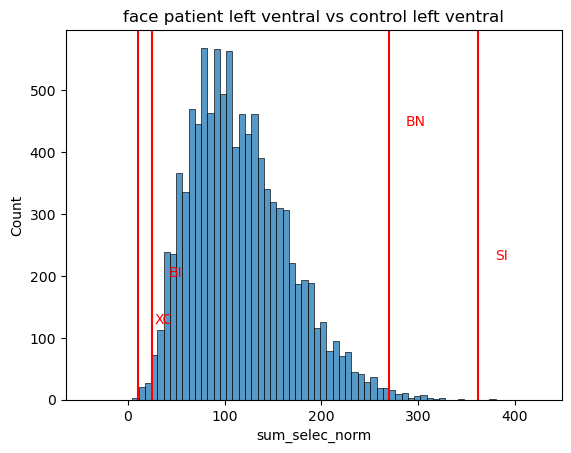

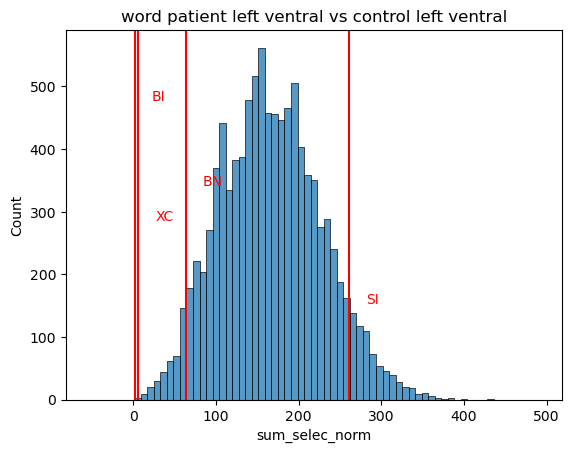

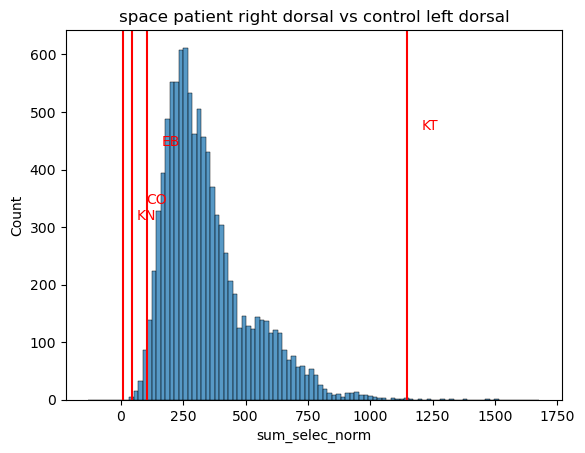

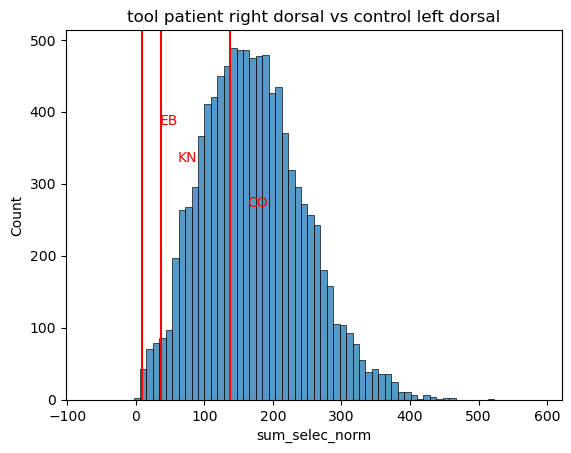

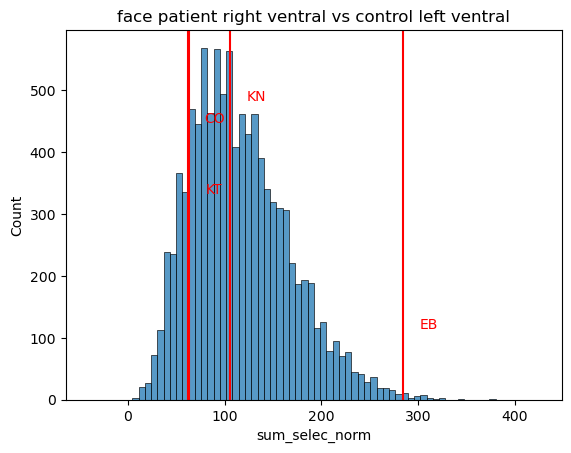

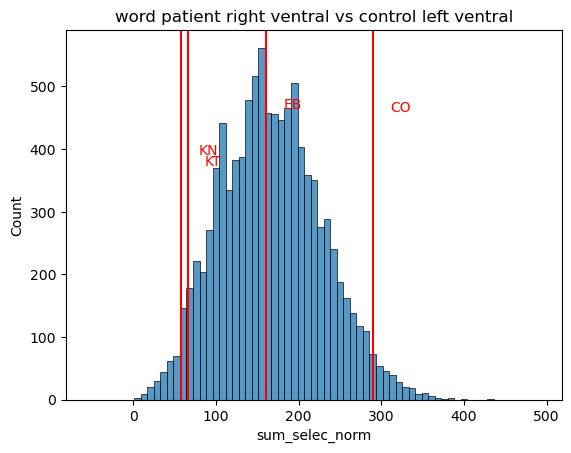

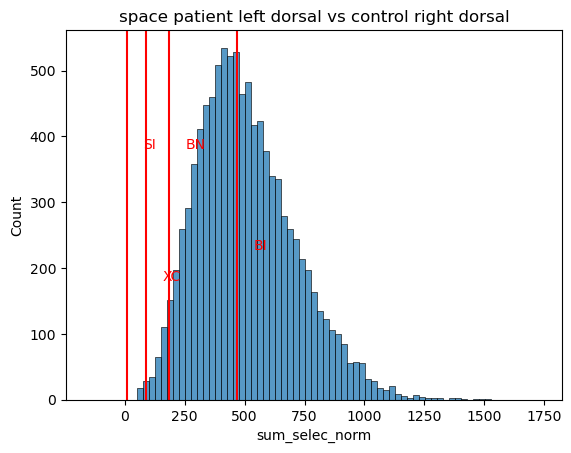

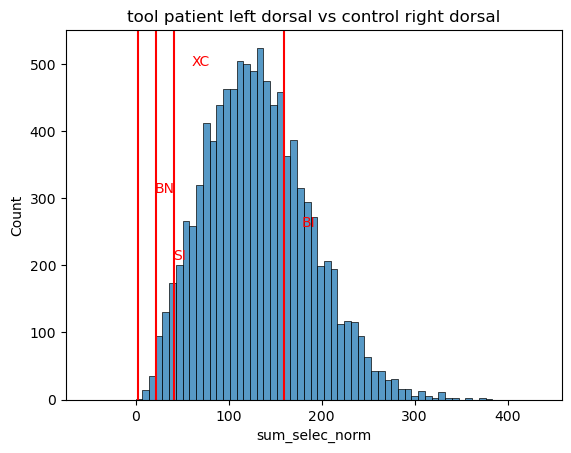

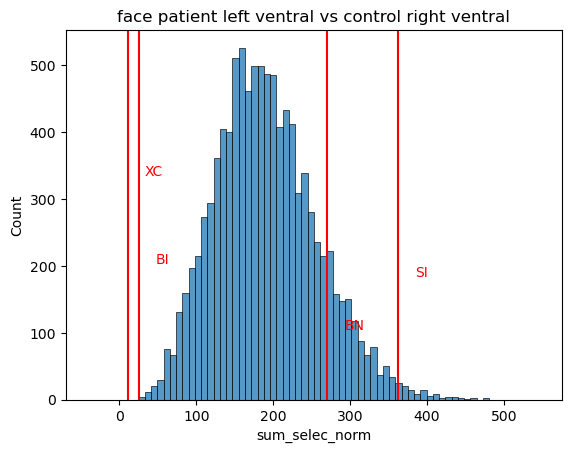

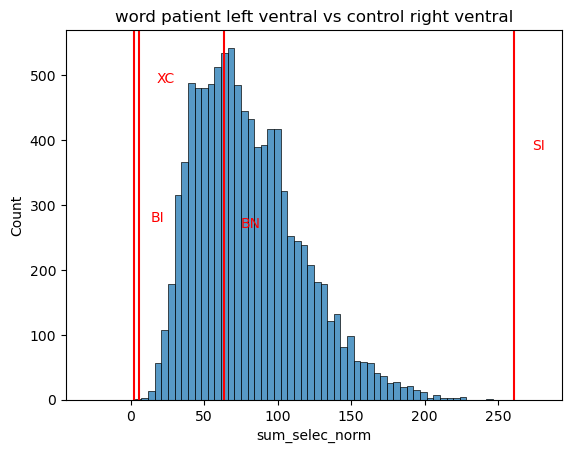

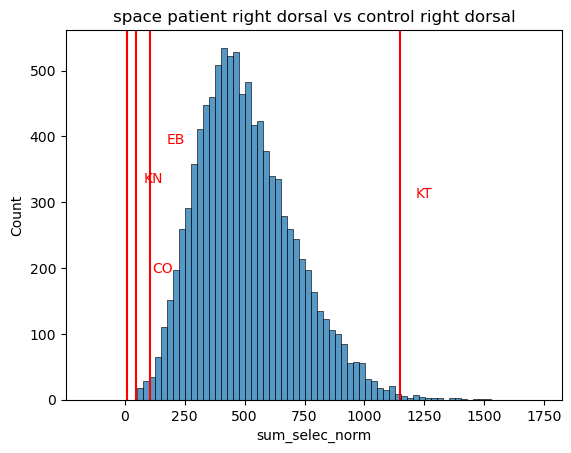

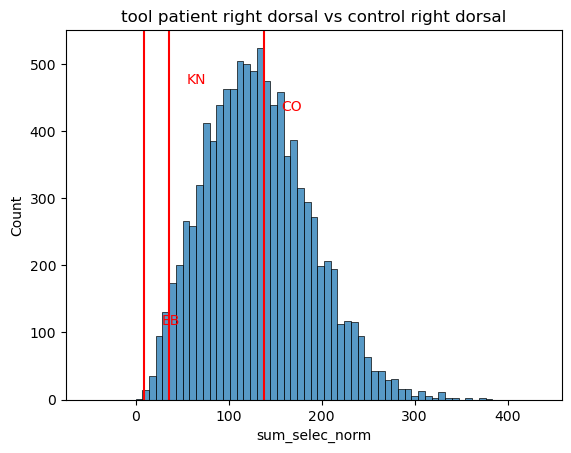

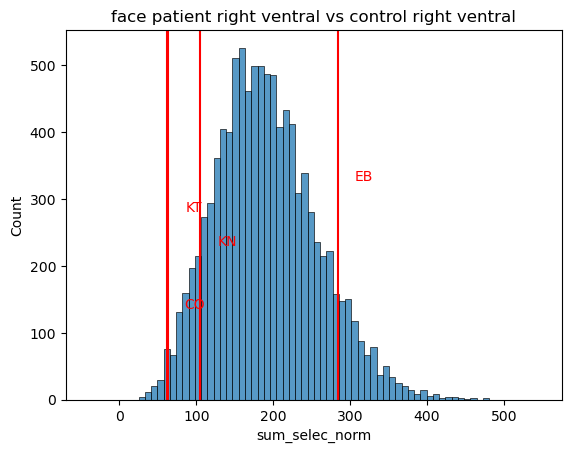

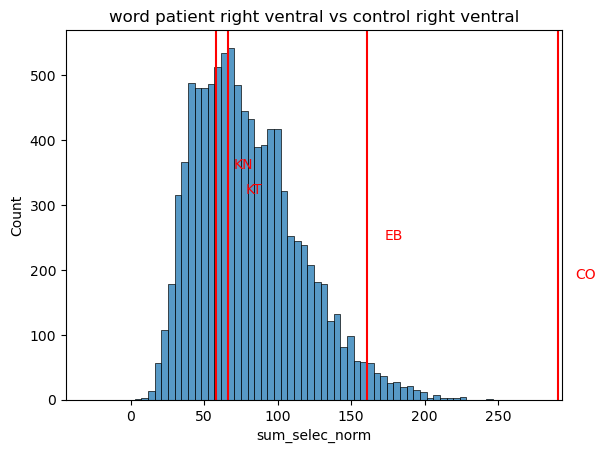

In [4]:
"""
Plot each individual patient's data on distribution of control data
"""

conds = ['space','feat', 'tool','non_tool', 'object','face', 'word']
rois = ['dorsal_visual_cortex','dorsal_visual_cortex',
'dorsal_visual_cortex', 'dorsal_visual_cortex', 
'ventral_visual_cortex', 'ventral_visual_cortex','ventral_visual_cortex']

conds = ['space', 'tool','face', 'word']
rois = ['dorsal_visual_cortex','dorsal_visual_cortex',
'ventral_visual_cortex', 'ventral_visual_cortex']

summary_val = ['mean_act', 'sum_selec_norm']
for val in summary_val:
    act_resamples = pd.read_csv(f'{results_dir}/{val}_resamples{suf}.csv')
    for control_hemi in hemis:

        for patient_hemi in hemis:
            for cond, roi in zip(conds, rois):
                control_col = f'{cond}_{control_hemi}_{roi}'

                control_data = act_resamples[control_col]
                
                #extract patient data from summary
                patient_data = data_summary[(data_summary['group'] == 'patient') & (data_summary['cond'] == cond) & (data_summary['hemi'] == patient_hemi) & (data_summary['roi'] == roi)][['sub',val]]
                #sub_names = patient_data = data_summary[(data_summary['group'] == 'patient') & (data_summary['cond'] == cond) & (data_summary['hemi'] == hemi) & (data_summary['roi'] == roi)]
                roi_name = roi.split('_')[0]
                title = f'{cond} patient {patient_hemi} {roi_name} vs control {control_hemi} {roi_name}'
                create_histplot(control_data, patient_data,'patient',val, title)
                plt.pause(.001)




space dorsal_visual_cortex
tool dorsal_visual_cortex
face ventral_visual_cortex
word ventral_visual_cortex
space dorsal_visual_cortex
tool dorsal_visual_cortex
face ventral_visual_cortex
word ventral_visual_cortex


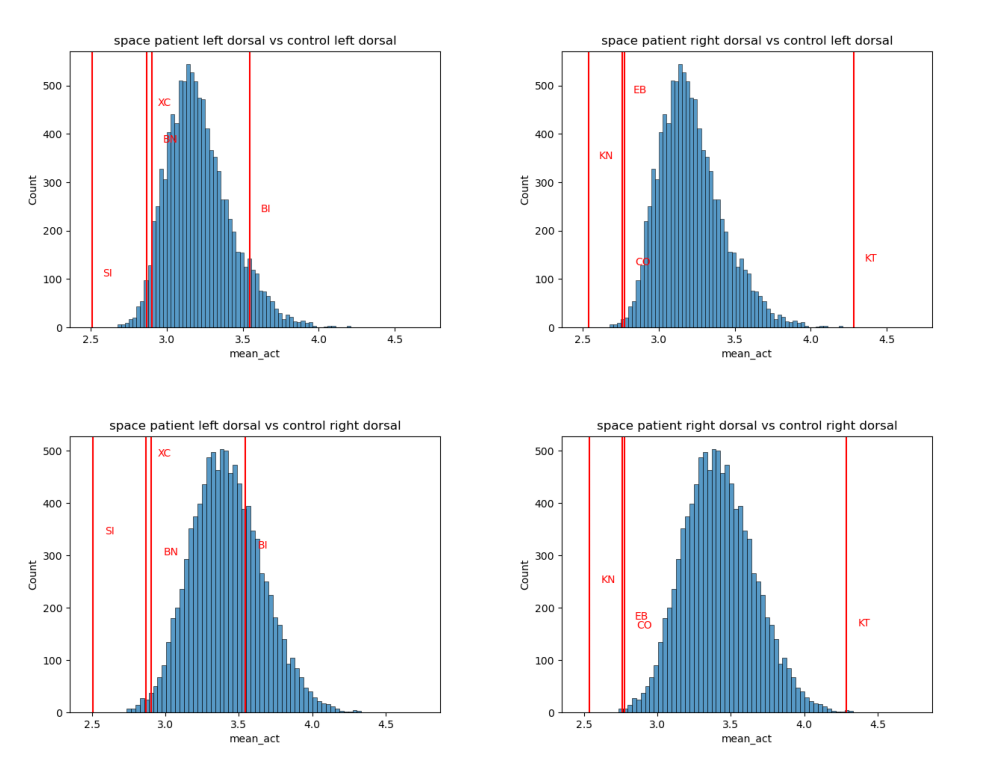

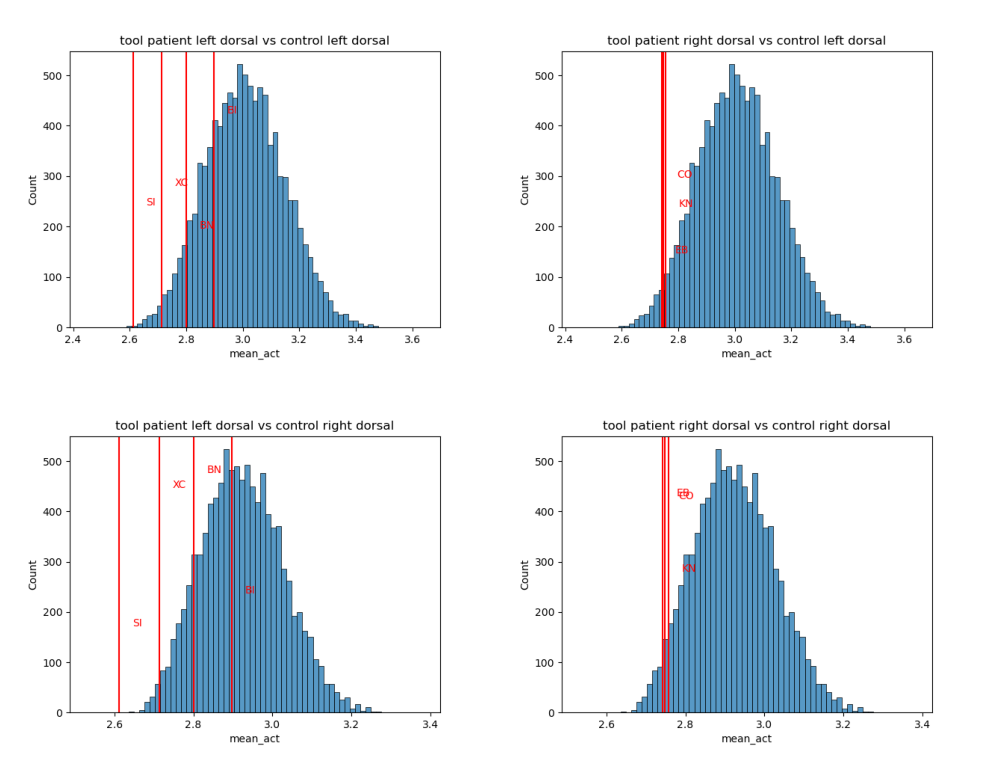

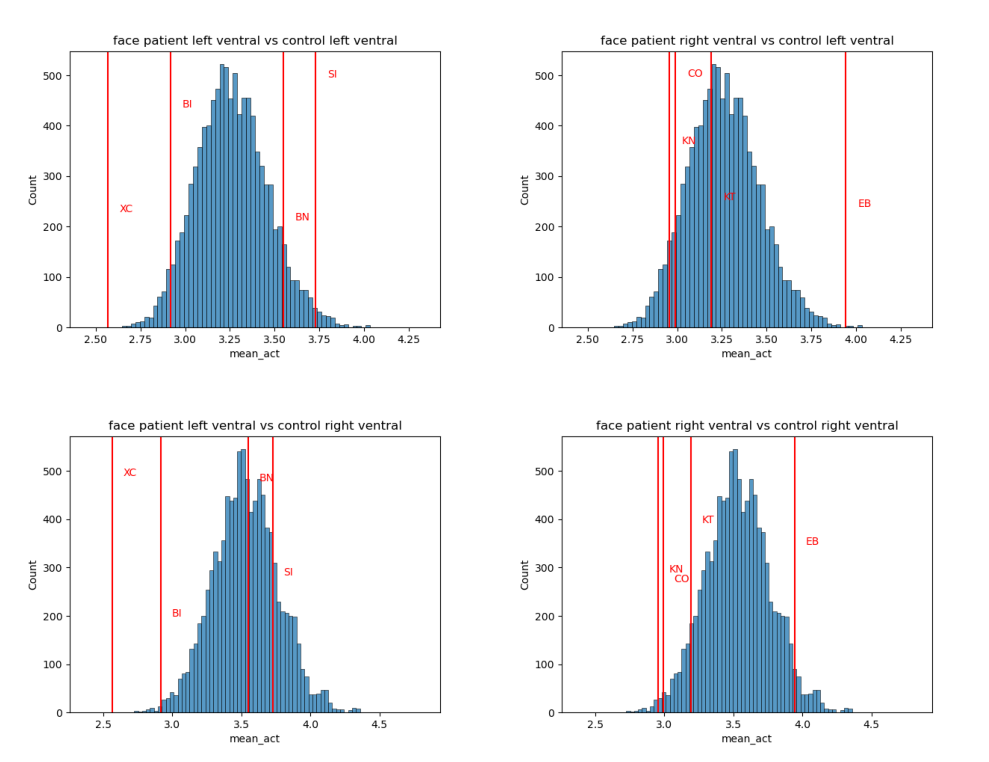

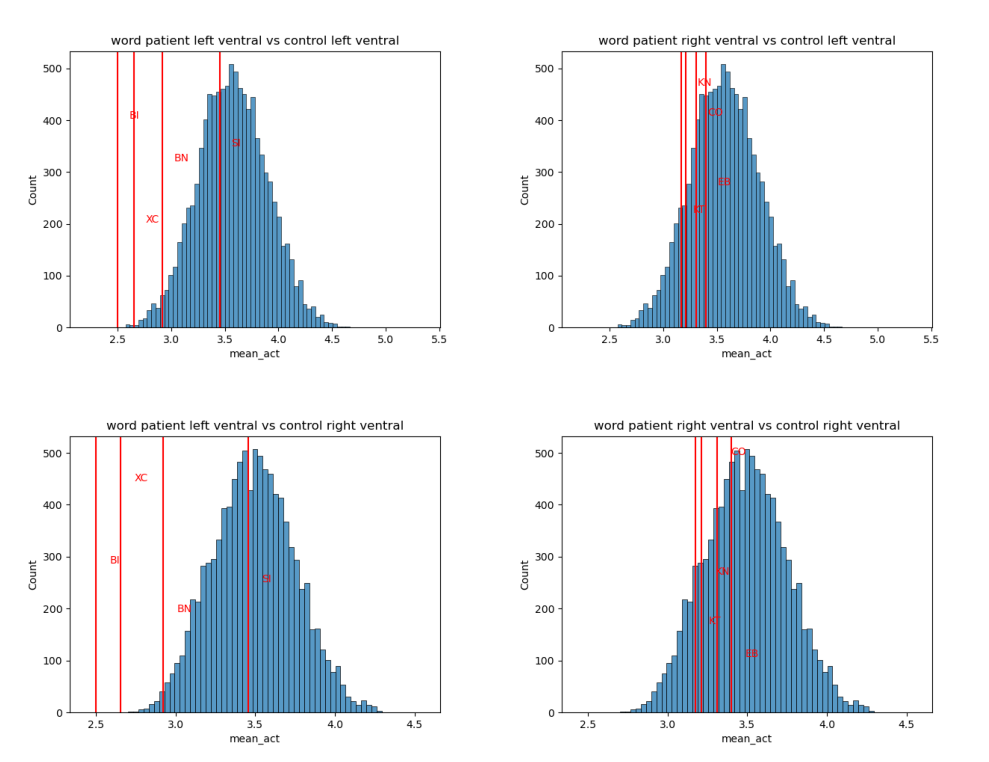

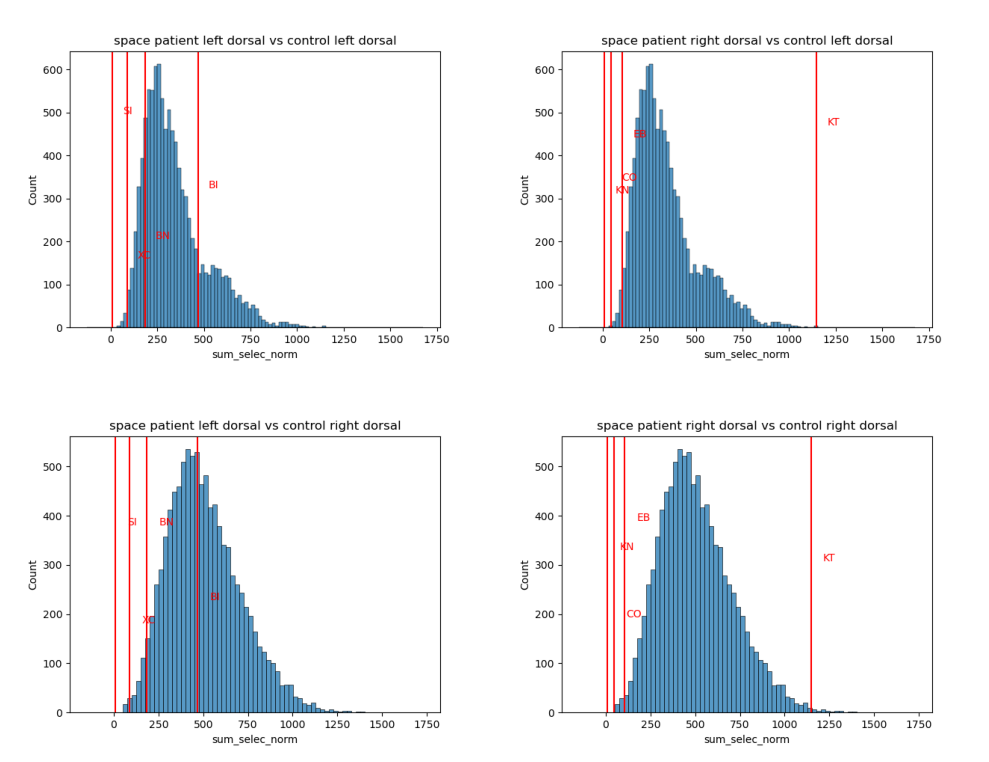

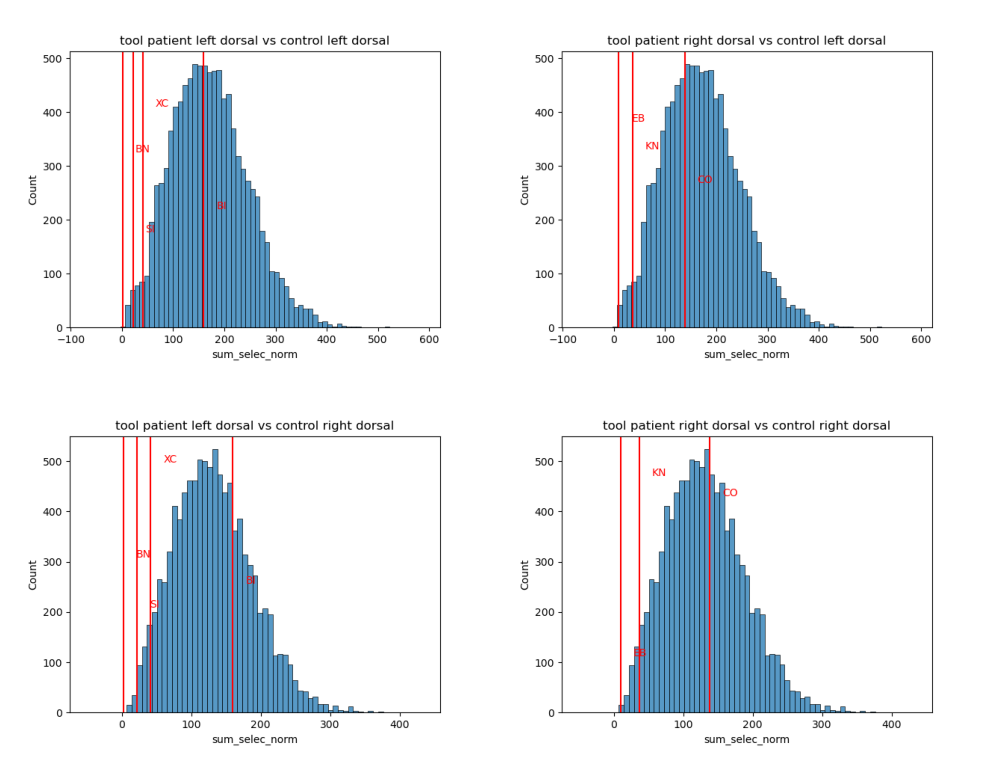

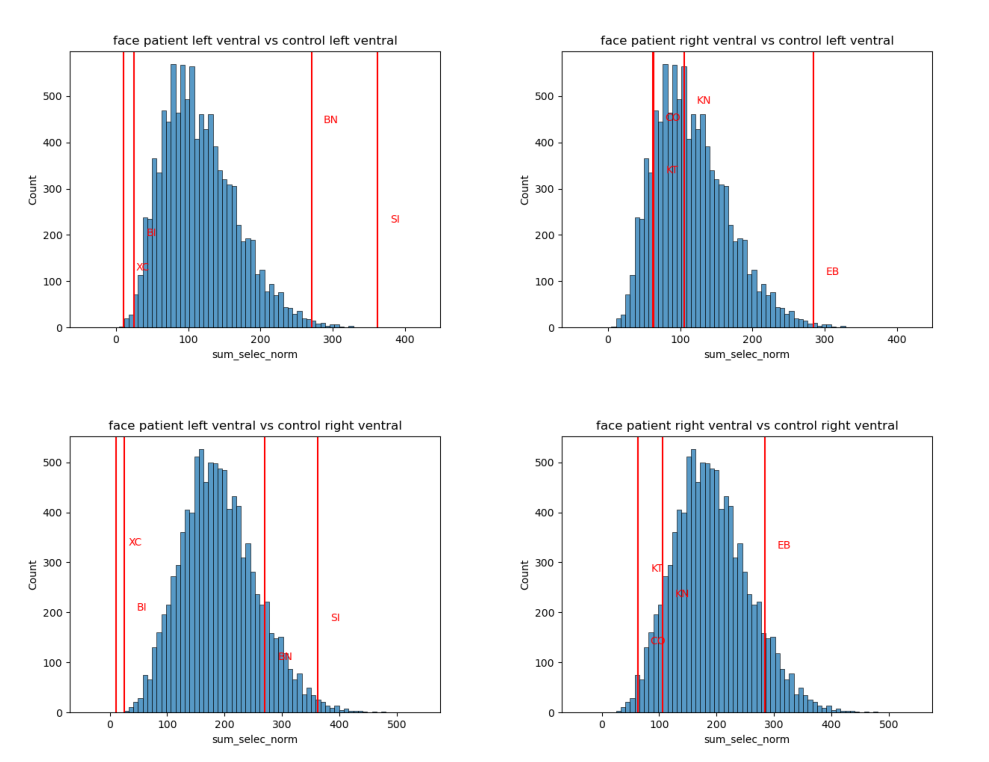

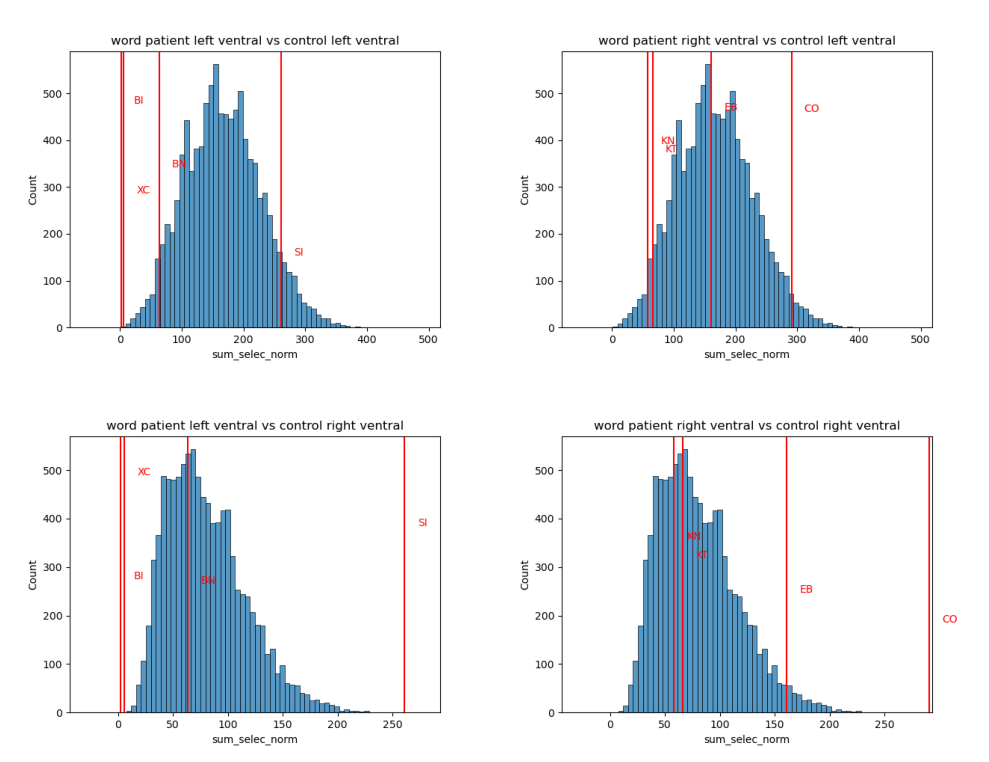

In [5]:
"""
Load each fig image and arrange in 2x2 subplot
"""


conds = ['space','feat', 'tool','non_tool', 'object','face', 'word']
rois = ['dorsal_visual_cortex','dorsal_visual_cortex',
'dorsal_visual_cortex', 'dorsal_visual_cortex', 
'ventral_visual_cortex', 'ventral_visual_cortex','ventral_visual_cortex']

conds = ['space', 'tool','face', 'word']
rois = ['dorsal_visual_cortex','dorsal_visual_cortex',
'ventral_visual_cortex', 'ventral_visual_cortex']

summary_val = ['mean_act', 'sum_selec_norm']
for val in summary_val:
    #act_resamples = pd.read_csv(f'{results_dir}/{val}_resamples{suf}.csv')
    for cond, roi in zip(conds, rois):
        print(cond,roi)
        fig, axs = plt.subplots(2,2, figsize = (10,8))
        fig.patch.set_visible(False)
        for patient_hemi in hemis:
            for control_hemi in hemis:
                roi_name = roi.split('_')[0]
                file_name = f'{val}_{cond}_patient_{patient_hemi}_{roi_name}_vs_control_{control_hemi}_{roi_name}{suf}'
                img = mpimg.imread(f'{fig_dir}/hist/indiv/{file_name}.png')
                axs[hemis.index(control_hemi),hemis.index(patient_hemi)].imshow(img)

                
                axs[hemis.index(control_hemi),hemis.index(patient_hemi)].spines['top'].set_visible(False)
                axs[hemis.index(control_hemi),hemis.index(patient_hemi)].spines['right'].set_visible(False)
                axs[hemis.index(control_hemi),hemis.index(patient_hemi)].spines['bottom'].set_visible(False)
                axs[hemis.index(control_hemi),hemis.index(patient_hemi)].spines['left'].set_visible(False)

                axs[hemis.index(control_hemi),hemis.index(patient_hemi)].get_xaxis().set_ticks([])
                axs[hemis.index(control_hemi),hemis.index(patient_hemi)].get_yaxis().set_ticks([])
                
            
        plt.tight_layout()
        #save figure
        plt.savefig(f'{fig_dir}/hist/{val}_{cond}_{roi}{suf}.jpg')



                


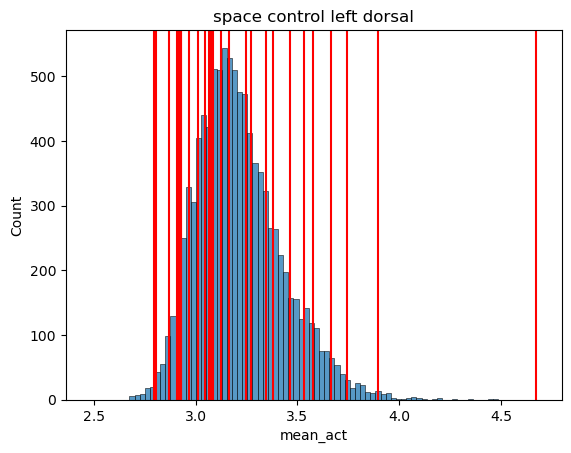

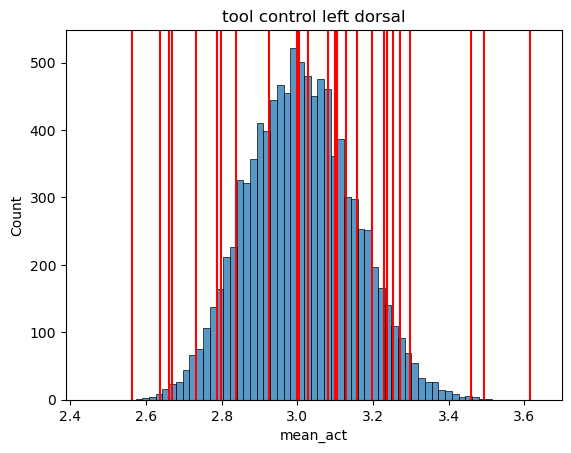

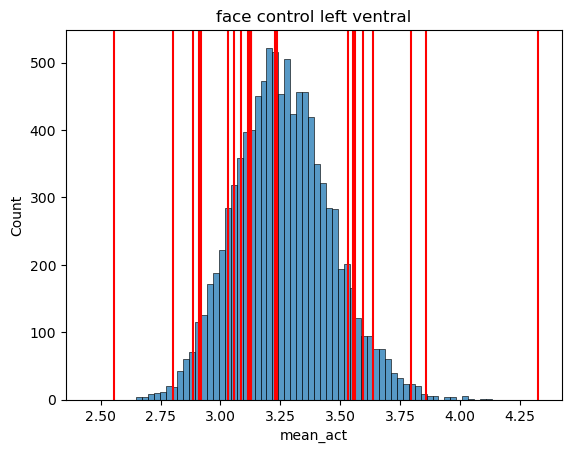

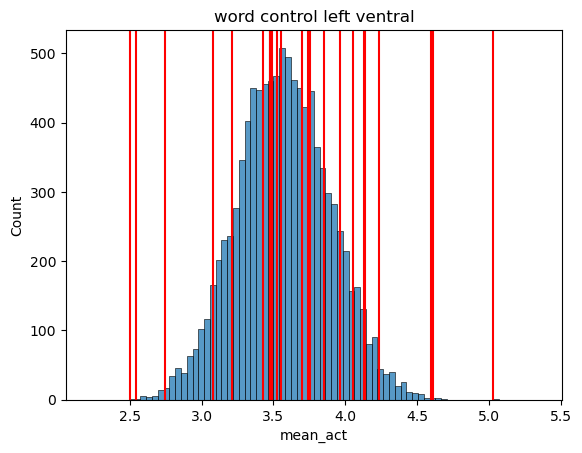

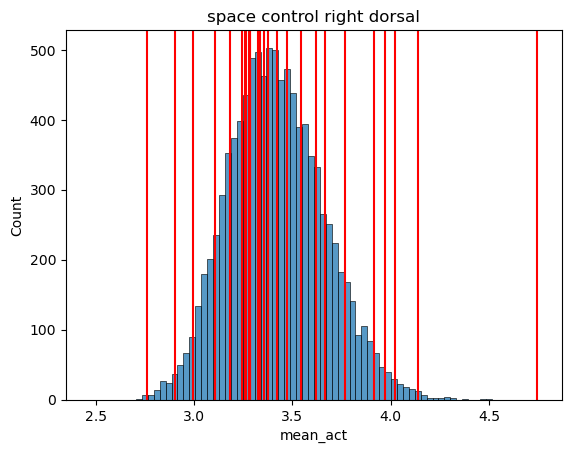

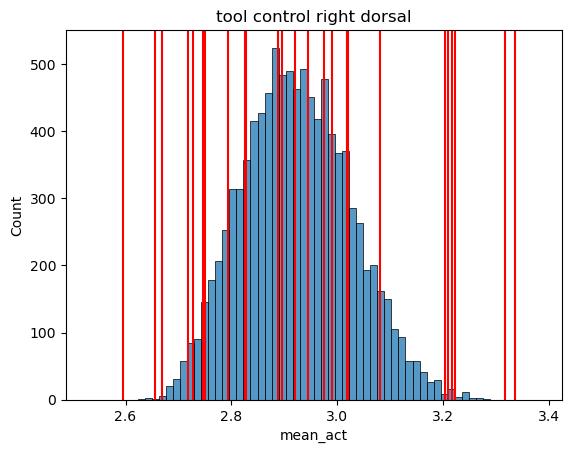

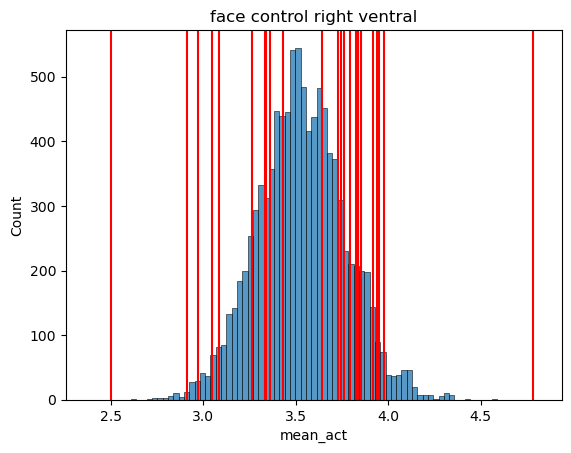

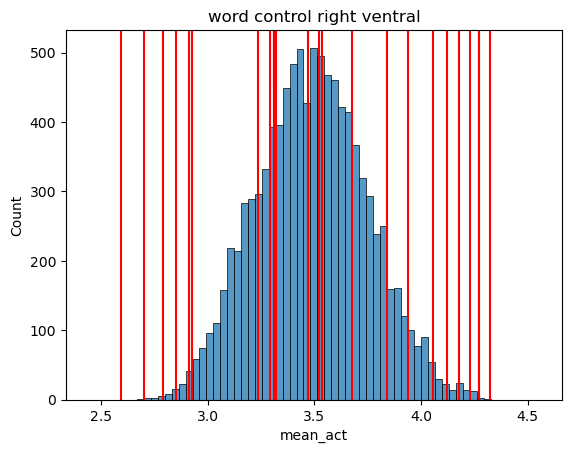

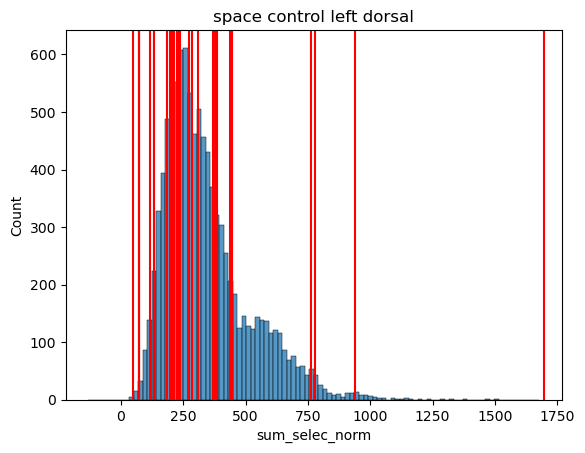

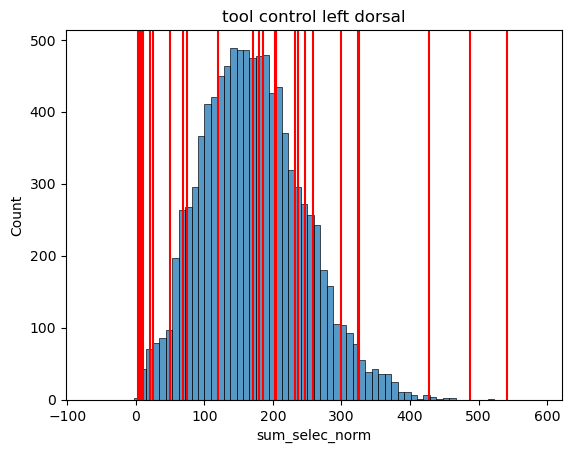

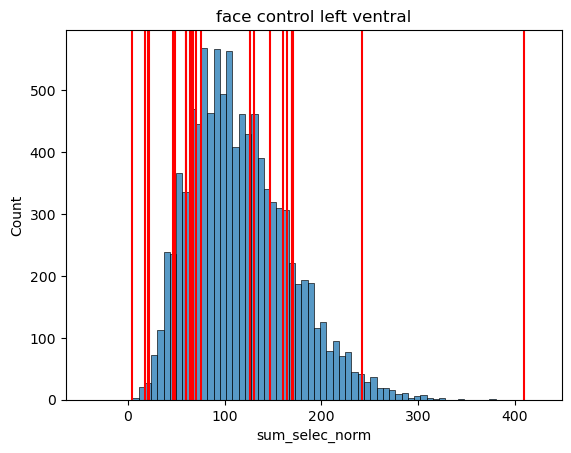

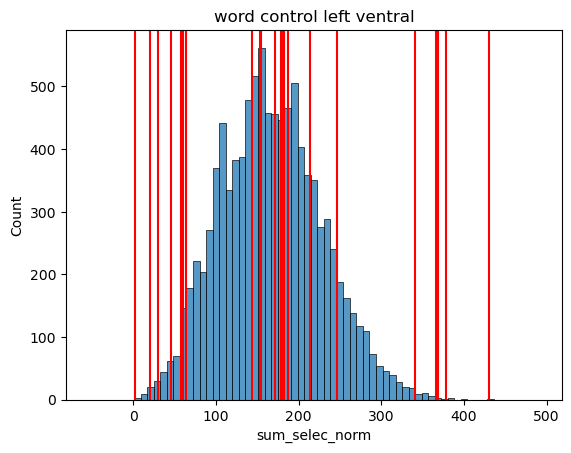

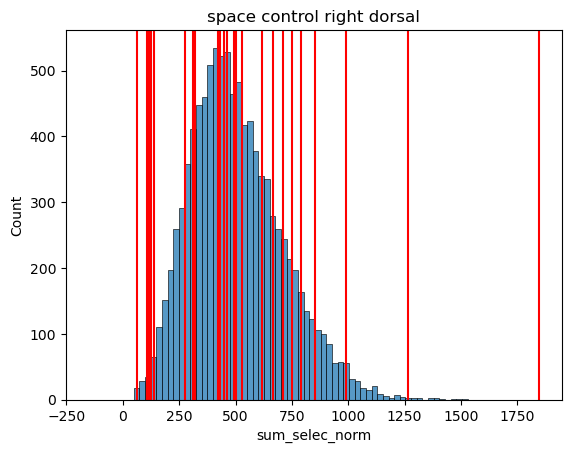

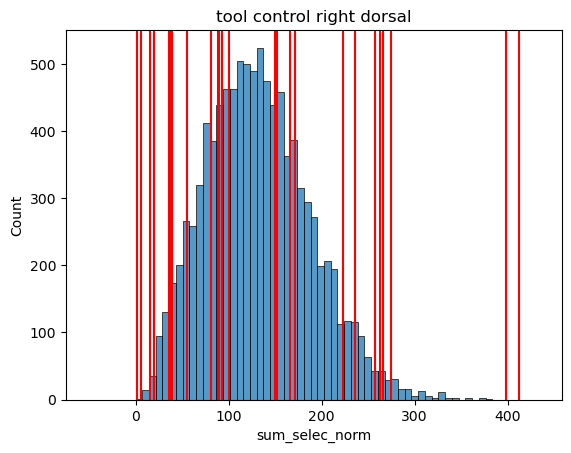

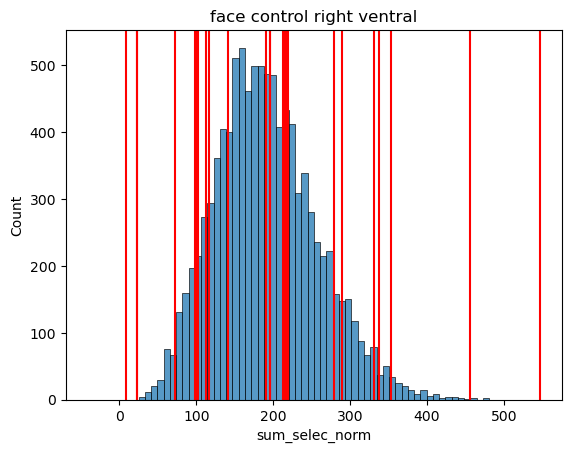

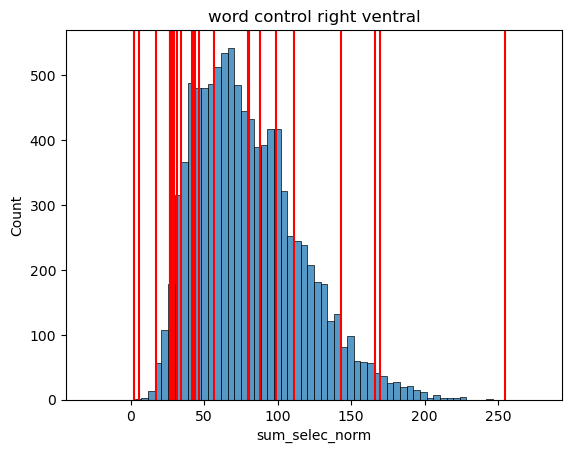

In [6]:
'''
Plot controls on distribution
'''


conds = ['space','feat', 'tool','non_tool', 'object','face', 'word']
rois = ['dorsal_visual_cortex','dorsal_visual_cortex',
'dorsal_visual_cortex', 'dorsal_visual_cortex', 
'ventral_visual_cortex', 'ventral_visual_cortex','ventral_visual_cortex']

conds = ['space', 'tool','face', 'word']
rois = ['dorsal_visual_cortex','dorsal_visual_cortex',
'ventral_visual_cortex', 'ventral_visual_cortex']

summary_val = ['mean_act', 'sum_selec_norm']
for val in summary_val:
    act_resamples = pd.read_csv(f'{results_dir}/{val}_resamples{suf}.csv')
    for control_hemi in hemis:

        for cond, roi in zip(conds, rois):
            control_col = f'{cond}_{control_hemi}_{roi}'

            control_boots = act_resamples[control_col]
            
            #extract patient data from summary
            control_data = data_summary[(data_summary['group'] == 'control') & (data_summary['cond'] == cond) & (data_summary['hemi'] == control_hemi) & (data_summary['roi'] == roi)][['sub',val]]
            #sub_names = patient_data = data_summary[(data_summary['group'] == 'patient') & (data_summary['cond'] == cond) & (data_summary['hemi'] == hemi) & (data_summary['roi'] == roi)]
            roi_name = roi.split('_')[0]
            title = f'{cond} control {control_hemi} {roi_name}'
            create_histplot(control_boots, control_data,'control',val, title)
            plt.pause(.001)




In [ ]:


control_conds = ['space_left_dorsal_visual_cortex', 'tool_right_dorsal_visual_cortex',
       'face_left_ventral_visual_cortex','word_right_ventral_visual_cortex'] + ['space_right_dorsal_visual_cortex', 'tool_left_dorsal_visual_cortex',
       'face_right_ventral_visual_cortex','word_left_ventral_visual_cortex'] 

patient_conds = ['space_left_dorsal', 'tool_right_dorsal',
         'face_left_ventral','word_right_ventral'] + ['space_right_dorsal', 'tool_left_dorsal',
         'face_right_ventral','word_left_ventral']

summary_val = 'mean_act'

#load act resamples
act_resamples = pd.read_csv(f'{results_dir}/{summary_val}_resamples.csv')
for cond in control_conds:
    control_data = act_resamples[cond]
    
    #split patient conds
    cond, hemi, roi = patient_conds[control_conds.index(cond)].split('_') 
    roi = roi + '_visual_cortex'
    
    #extract patient data from summary
    patient_data = data_summary[(data_summary['group'] == 'patient') & (data_summary['cond'] == cond) & (data_summary['hemi'] == hemi) & (data_summary['roi'] == roi)][['sub',summary_val]]
    #sub_names = patient_data = data_summary[(data_summary['group'] == 'patient') & (data_summary['cond'] == cond) & (data_summary['hemi'] == hemi) & (data_summary['roi'] == roi)]

    
    create_histplot(control_data, patient_data,summary_val, cond)
    plt.pause(.001)




In [ ]:
patient_data

In [ ]:
cond, hemi, roi

In [ ]:
patient_data